# Epam Model, End-To-End


To create the environment, run the command in a terminal:

```sh
!conda create --name am-env -c conda-forge python=3.8 pandas matplotlib seaborn pymc3 arviz bottleneck requests boto3 s3fs fsspec ipywidgets graphviz python-graphviz
```

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, RocCurveDisplay, f1_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import ipywidgets as w

from epam_e2e import load_training_data, cleanup_df, id_cols, basic_target, EpamModel

In [2]:
s3 = "s3://epam-hack4med-dataset"
model_file = "bayes_1.zip"
output_file = "bayes_full.zip"
seed = 42

## Data loading and preparation

In [3]:
Xy_raw = load_training_data(s3)

In [4]:
Xy = cleanup_df(Xy_raw)

In [5]:
if basic_target in Xy:
    X = Xy.drop(columns=[basic_target])
    y = Xy[basic_target]
else:
    X = Xy
    y = pd.Series(0, index=Xy.index)

In [6]:
# Stratified sampling
train, test = train_test_split(X.index, test_size=0.2, stratify=y, random_state=seed)

## Fit or Load Bayesian model

... or skip to "Load Model"

In [7]:
model = EpamModel(oversample=True)

In [8]:
if Path(model_file).exists():
    model.load(model_file)
    y_ins = model.predict(X.loc[train])
else:
    y_ins = model.fit(X.loc[train], y.loc[train])
    model.save(model_file)

## Predictions

### In-sample

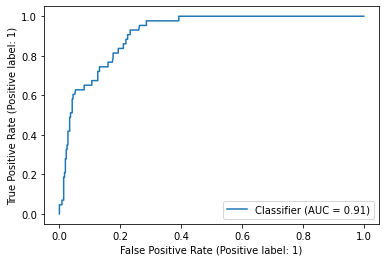

In [9]:
RocCurveDisplay.from_predictions(y.loc[train], y_ins);

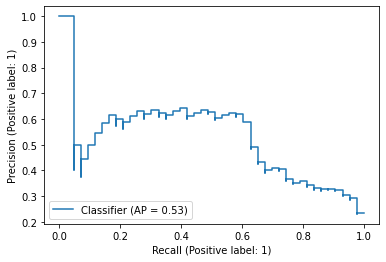

In [10]:
PrecisionRecallDisplay.from_predictions(y.loc[train], y_ins);

### Out-of-sample

In [11]:
y_oos = model.predict_proba(X.loc[test])

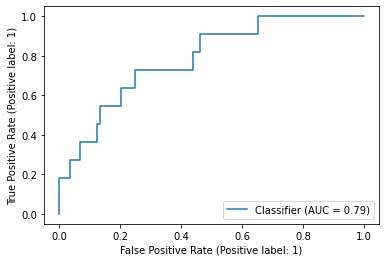

In [12]:
RocCurveDisplay.from_predictions(y.loc[test], y_oos);

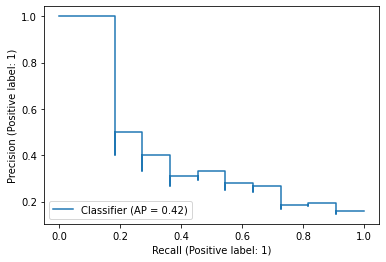

In [13]:
PrecisionRecallDisplay.from_predictions(y.loc[test], y_oos);

In [14]:
roc_auc_score(y.loc[test], y_oos)

0.7854954034729316

## Re-fit Model on All Data

In [15]:
model = EpamModel(oversample=True)

In [16]:
if Path(output_file).exists():
    model.load(output_file)
    y_all = model.predict(X)
else:
    y_all = model.fit(X, y)
    model.save(output_file)

54 446 8


Only 200 samples in chain.
Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [h_c_mask_incl, c_mask_coef_raw, c_vals_coef, h_b_mask_incl, b_mask_coef_raw, b_vals_coef, a_coef_raw, h_a_incl, avg]
>BinaryGibbsMetropolis: [a_incl, b_mask_incl, c_mask_incl]


Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 96 seconds.
/home/ec2-user/anaconda3/envs/am-env/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


## Model Diagnostics

This dataframe gives the summary for all coefficients:

In [17]:
pm.summary(model.ifd_)

/home/ec2-user/anaconda3/envs/am-env/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg,-1.798,0.860,-3.312,-0.057,0.026,0.021,1160.0,493.0,1.01
a_coef_raw[PLEC],0.029,0.902,-1.593,1.880,0.019,0.035,2322.0,609.0,1.01
a_coef_raw[N58.11.11342_PCT_out_of_bound],-0.205,1.044,-2.127,1.793,0.026,0.035,1648.0,653.0,1.01
a_coef_raw[I81.11.1112_CRP_out_of_bound],-0.031,0.950,-1.874,1.711,0.020,0.037,2322.0,568.0,1.00
a_coef_raw[G49.122.1113_DD_out_of_bound],0.074,0.895,-1.641,1.645,0.025,0.035,1285.0,557.0,1.00
...,...,...,...,...,...,...,...,...,...
logit[711],0.880,0.501,-0.079,1.796,0.015,0.011,1138.0,677.0,1.00
logit[712],-1.170,0.379,-1.905,-0.518,0.011,0.008,1121.0,773.0,1.01
logit[713],-0.682,0.383,-1.414,-0.049,0.012,0.009,990.0,765.0,1.00
logit[714],1.948,0.721,0.684,3.261,0.017,0.014,1725.0,630.0,1.01


This forest plot gives a high-level view of the distribution of coefficients:

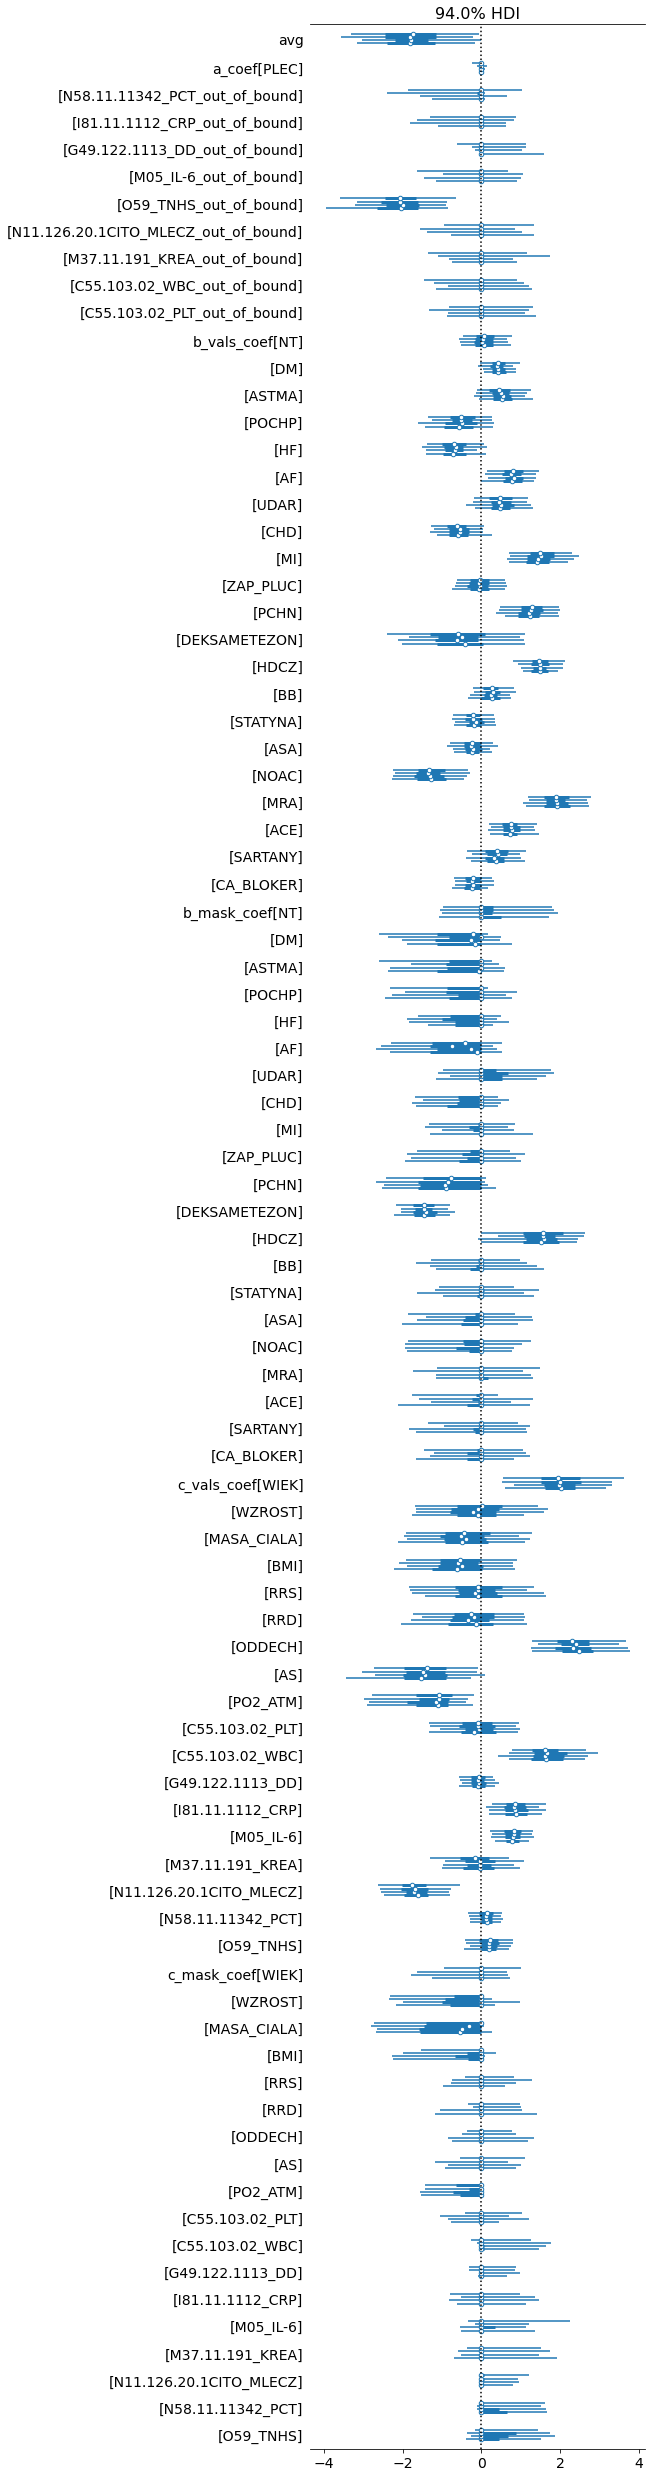

In [18]:
model.plot_forest();

## Interactive

This creates an interactive prediction, based on the values of a real patient.

This demo will only work in a Jupyter notebook, not JupyterLab.

In [19]:
from epam_e2e import make_interactive

In [20]:
make_interactive(model, Xy_raw);

interactive(children=(IntText(value=0, description='Base Case'), Output()), _dom_classes=('widget-interact',))